# Homework 2
#### Noah Franz
#### Due: 10/3/24

## Problem 1

In [2]:
import pandas as pd
import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

In [63]:
col_names = [
    "name",
    "ra_hours",
    "ra_minutes",
    "ra_seconds",
    "dec_degrees",
    "dec_arcminutes",
    "dec_arcseconds",
    "E(B-V)",
    "dist_mod",
    "dist_mod_up",
    "dist_mod_low",
    "vrad",
    "vrad_up",
    "vrad_low",
    "Vmag",
    "Vmag_up",
    "Vmag_low",
    "PA",
    "PA_up",
    "PA_low",
    "e",
    "e_up",
    "e_low",
    "muVo",
    "muVo_up",
    "muVo_low",
    "rh",
    "rh_up",
    "rh_low",
    "sigma_s",
    "sigma_s_up",
    "sigma_s_low",
    "vrot_s",
    "vrot_s_up",
    "vrot_s_low",
    "M_HI",
    "sigma_g",
    "sigma_g_up",
    "sigma_g_low",
    "vrot_g",
    "vrot_g_up",
    "vrot_g_low",
    "Fe_H",
    "Fe_H_up",
    "Fe_H_low",
    "F",
    "refs"
]

nearby_galaxies = pd.read_csv("NearbyGalaxies.dat", skiprows=37, sep=" ", index_col=False, names=col_names)
n_og = len(nearby_galaxies)
nearby_galaxies = nearby_galaxies[(nearby_galaxies.Vmag != 999) * (nearby_galaxies.dist_mod != 999)]
print(f"Cut out {n_og-len(nearby_galaxies)} galaxies for poor Vmag or poor Distance Modulus")

vmags, dist_mod = nearby_galaxies.Vmag, nearby_galaxies.dist_mod
abs_mag = (vmags - dist_mod).to_list()

# add the milky way
abs_mag.append(-20.6) # from https://lweb.cfa.harvard.edu/~dfabricant/huchra/seminar/galaxies/

# and add M31
abs_mag.append(-21.5) # from https://arxiv.org/abs/astro-ph/0511045

print(abs_mag)

Cut out 2 galaxies for poor Vmag or poor Distance Modulus
[-14.389999999999999, -13.500000000000002, -2.5, -2.410000000000002, -4.709999999999999, -2.8999999999999986, -1.3000000000000007, -2.3999999999999986, -3.879999999999999, 0.019999999999999574, -1.799999999999999, -4.5, -4.25, -2.9400000000000013, -1.8599999999999994, -2.5299999999999994, -4.379999999999999, -3.51, -5.750000000000002, -3.200000000000001, -3.9200000000000017, -18.12, -1.6099999999999994, -3.8000000000000007, -5.229999999999999, -16.830000000000002, -6.02, -8.709999999999999, -9.03, -1.5600000000000023, -3.5500000000000007, -3.3000000000000007, -10.820000000000002, -2.370000000000001, -9.270000000000001, -0.33000000000000185, -3.3099999999999987, -3.3200000000000003, -5.119999999999999, -4.359999999999999, -9.43, -3.469999999999999, -8.200000000000001, -3.4499999999999993, -5.830000000000002, -4.600000000000001, -9.030000000000001, -13.46, -4.990000000000002, -5.17, -4.399999999999999, -4.220000000000002, -4.5, -4

Text(0.5, 0, 'Absolute V-Band Magnitude')

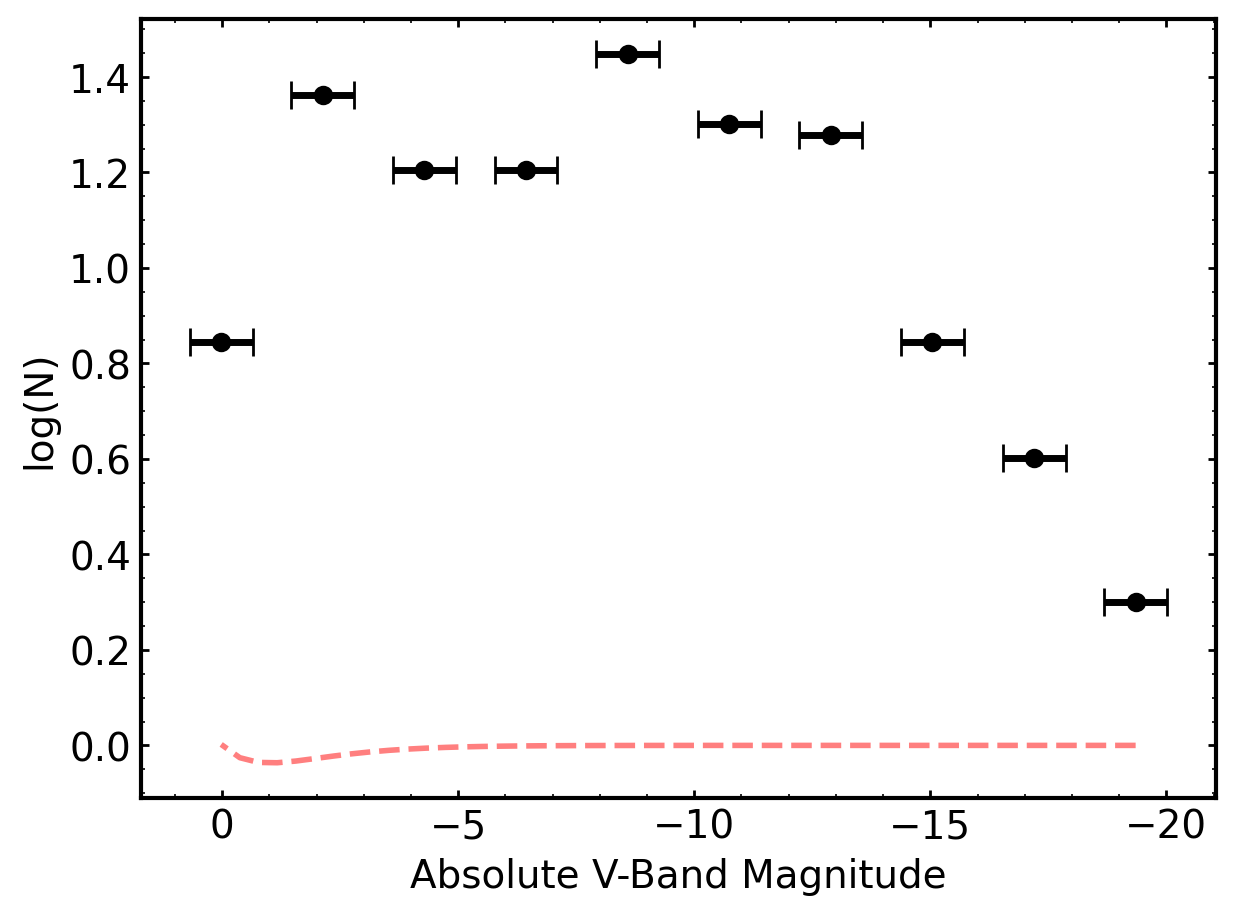

In [69]:
def schechter(M_V, phi_star, M_V_star, alpha):
    return phi_star * (M_V / M_V_star)**alpha * np.exp(M_V/M_V_star)

# reformat the data
nbins = int(abs(min(abs_mag) - max(abs_mag))) // 2
counts, bins = np.histogram(
    abs_mag, 
    bins=nbins
)

mids = 0.5*(bins[1:] + bins[:-1])
probs = counts / np.sum(counts)

mean = np.sum(probs * mids)  
sd = np.log10(np.sqrt(np.sum(probs * (mids - mean)**2)))

# plot the N vs. Luminosity
fig, ax = plt.subplots()
ax.errorbar(bins[1:], np.log10(counts), xerr=sd, capsize=5, color='k', linestyle="none", marker="o")

# fit with a schechter function
phi_star = 0.1
M_V_star = 1
alpha = 1
xfit = np.linspace(min(bins[1:]), max(bins[1:]))
fit = schechter(xfit, phi_star, M_V_star, alpha)
ax.plot(xfit, fit, 'r--', alpha=0.5, linewidth=2)

# some other labels
fig.gca().invert_xaxis()

ax.set_ylabel("log(N)")
ax.set_xlabel("Absolute V-Band Magnitude")